## using log simulation

# importing math sympy equivalence function 

In [1]:
!git clone https://github.com/MARIO-Math-Reasoning/MARIO_EVAL.git
!cd MARIO_EVAL
!cd latex2sympy && pip install . && cd ..
!pip install -e .

Cloning into 'MARIO_EVAL'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 238 (delta 97), reused 210 (delta 69), pack-reused 0 (from 0)
Receiving objects: 100% (238/238), 3.57 MiB | 12.53 MiB/s, done.
Resolving deltas: 100% (97/97), done.
/bin/bash: line 0: cd: latex2sympy: No such file or directory
Obtaining file:///kaggle/working
ERROR: file:///kaggle/working does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
!pip install antlr4-python3-runtime==4.11.1
!pip install timeout_decorator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 2.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for timeout_decorator: filename=timeout_decorator-0.5.0-py3-none-any.whl size=5006 sha256=7de19841e755cd694ae036fac965c83c32dcc2e2fd58fed7f95ee4bb533b8b57
  Stored in directory: /root/.cache/pip/wheels/68/2f/bc/76f1192d474666d41ae6f09813fccbd00fe3f07e8261c4cff5
Successfully built timeout_decorator


In [3]:
%cd /kaggle/working/MARIO_EVAL
from math_evaluation import is_equiv

/kaggle/working/MARIO_EVAL


In [4]:
import os
import re
import signal
import subprocess
import tempfile
from collections import Counter
from contextlib import contextmanager
from dataclasses import dataclass

In [5]:



code1 = '''
```python
import sympy as sp

# Define variable
x = sp.Symbol('x')

# Example equation: 3x + 2 = 11
equation = sp.Eq(3 * x + 2, 11)

# Solve equation
solution = sp.solve(equation, x)
solution

```
'''


code2 = '''
```python
import sympy as sp

# Define variable
x = sp.Symbol('x')

# Example equation: x^2 - 5x + 6 = 0
equation = sp.Eq(x**2 - 5 * x + 6, 0)

# Solve equation
solution = sp.solve(equation, x)
solution
```
'''

code3 = '''
```python
import sympy as sp

# Example expression: (x^2 - 1) / (x - 1)
x = sp.Symbol('x')
expression = (x**2 - 1) / (x - 1)

# Simplify expression
simplified_expr = sp.simplify(expression)
simplified_expr
```
'''


code4 = '''
```python
import sympy as sp

# Define variables
x, y = sp.symbols('x y')

# Example equations: 2x + y = 10, 3x - y = 5
equations = [sp.Eq(2 * x + y, 10), sp.Eq(3 * x - y, 5)]

# Solve the system of equations
solution = sp.solve(equations, (x, y))
solution
```
'''



code5 = '''
```python
import sympy as sp

# Example numbers: 48 and 60
a = 48
b = 60

# Compute GCD
gcd = sp.gcd(a, b)
gcd
```
'''



code6 = '''
```python
import sympy as sp

# Example numbers: 12 and 18
a = 12
b = 18

# Compute LCM
lcm = sp.lcm(a, b)
lcm
```
'''



code7 = '''
```python
import sympy as sp

# Define variable
x = sp.Symbol('x')

# Example inequality: 2x - 3 > 5
inequality = sp.Gt(2 * x - 3, 5)

# Solve the inequality
solution = sp.solve(inequality, x)
solution
```
'''


code8 = '''
```python
import sympy as sp

# Define variable
x = sp.Symbol('x')

# Example expression: x^2 - 9
expression = x**2 - 9

# Factorize expression
factorized_expr = sp.factor(expression)
factorized_expr
```
'''


code9 = '''
```python
import sympy as sp

# Define variable
x = sp.Symbol('x')

# Example expression: (x + 2)^3
expression = (x + 2)**3

# Expand expression
expanded_expr = sp.expand(expression)
expanded_expr
```
'''


code10 = '''
```python
import sympy as sp

# Define variable
x = sp.Symbol('x')

# Example function: f(x) = 3x^2 + 4x + 1
function = 3 * x**2 + 4 * x + 1

# Compute the derivative
derivative = sp.diff(function, x)
derivative
```
'''


In [6]:
class PythonREPL:
    def __init__(self, timeout=5):
        self.timeout = timeout

    @contextmanager
    def time_limit(self, seconds):
        def signal_handler(*_):
            raise TimeoutError(f"Timed out after {seconds} seconds.")

        signal.signal(signal.SIGALRM, signal_handler)
        signal.alarm(seconds)
        try:
            yield
        finally:
            signal.alarm(0)

    def __call__(self, query):
        query = "import math\nimport numpy as np\nimport sympy as sp\n" + query
        query = query.strip().split("\n")
        if "print(" not in query[-1]:
            if "#" in query[-1]:
                query[-1] = query[-1].split("#")[0]
            query[-1] = "print(" + query[-1] + ")"
        query = "\n".join(query)
        with tempfile.TemporaryDirectory() as temp_dir:
            temp_file_path = os.path.join(temp_dir, "tmp.py")
            with open(temp_file_path, "w", encoding="utf-8") as f:
                f.write(query)
            with self.time_limit(self.timeout):
                result = subprocess.run(
                    ["python3", temp_file_path],
                    capture_output=True,
                    check=False,
                    text=True,
                    timeout=self.timeout,
                )
                if result.returncode == 0:
                    output = result.stdout
                    return True, output.strip()
                error_msg = result.stderr.strip()
                msgs = error_msg.split("\n")
                new_msgs = []
                want_next = False
                for m in msgs:
                    if "Traceback" in m:
                        new_msgs.append(m)
                    elif m == msgs[-1]:
                        new_msgs.append(m)
                    elif temp_file_path in m:
                        st = m.index('"/') + 1 if '"/' in m else 0
                        ed = m.index(temp_file_path) + 1 if temp_file_path in m else None
                        clr = m[st:ed] if not ed else m[st:]
                        m = m.replace(clr, "")
                        new_msgs.append(m)
                        want_next = True
                    elif want_next:
                        new_msgs.append(m)
                        want_next = False
                error_msg = "\n".join(new_msgs)
                return False, error_msg.strip()
            

def execute_completion(executor, completion, return_status, last_code_block):
    executions = re.findall(r"```python(.*?)```", completion, re.DOTALL)
    if len(executions) == 0:
        return completion, False if return_status else completion
    if last_code_block:
        executions = [executions[-1]]
    outputs = []
    successes = []
    for code in executions:
        success = False
        for lib in ("subprocess", "venv"):
            if lib in code:
                output = f"{lib} is not allowed"
                outputs.append(output)
                successes.append(success)
                continue
        try:
            success, output = executor(code)
        except TimeoutError as e:
            print("Code timed out")
            output = e
        if not success and not return_status:
            output = ""
        outputs.append(output)
        successes.append(success)
    output = str(outputs[-1]).strip()
    success = successes[-1]
    if return_status:
        return output, success
    return output


def postprocess_completion(text, return_status, last_code_block):
    executor = PythonREPL()
    result = execute_completion(executor, text, return_status=return_status, last_code_block=last_code_block)
    del executor
    return result

In [7]:
answer,sucess=postprocess_completion(code10,True,True)
print(answer)

6*x + 4


In [12]:
import re
import numpy as np
import sympy as sp

# Example function to define your executor or transformation logic
def replacement_function(num, modifier):
    return num + modifier  # Add the modifier to the number



class valuation:
    def __init__(self):
        self.sensitivity=None
        self.scale=None
        self.executor=PythonREPL()
        
        
        self.simualtes=[0,0.001,0.01,0.1,1,10,100,1000]
        
    def postprocess_completion(self,text, return_status=True, last_code_block=True):
        executor = PythonREPL()
        result = execute_completion(executor, text, return_status=return_status, last_code_block=last_code_block)
        del executor
        return result
    
    def type_check(self,expr_str):
       
       
        expr = sp.sympify(expr_str)
        
        # Check if the expression is a real number
        if expr.is_real:
            return "Real"

        # Check if the expression is a complex number
        if expr.is_complex:
            return "Complex"

        # Check if the expression is a polynomial
        if expr.is_polynomial():
            return "Polynomial"

        # Otherwise, classify as other
        return "Other"

    def modifier(self,code):
        pattern = r'\d+\.?\d*'
        modified_strings = []
        for modifier in self.simualtes:
 
            def replace_match(match):
                num = float(match.group())  # Convert the matched number to a float
                return str(replacement_function(num, modifier))  # Apply replacement with modifier

            modified_string = re.sub(pattern, replace_match,code)
            modified_strings.append(modified_string)
      
        return modified_strings
        
    def similarity_check(self, actual_answer, predicted_answer):
        act_answers = []
        pre_answers = []
        equivalent =is_equiv(actual_answer,predicted_answer)
        if equivalent: 
            return 1
        

        else:
            mods_act = self.modifier(actual_answer)
            for sti in mods_act:
                answer,sucess = self.postprocess_completion(sti)
                if not sucess :
                    answer=-100000

                if self.type_check(answer)!="Real":
                    print("others")
                    return int(equivalent) 

                act_answers.append(answer)

            # Process predicted answers
            mods_pred = self.modifier(predicted_answer)
            for sti in mods_pred:
                answer,sucess = self.postprocess_completion(sti)



                if not sucess :
                    answer=100000

                if self.type_check(answer)!="Real":
                    print("others")
                    answer=100000
                    pass # solve by other methods 

                pre_answers.append(answer) 




            print(act_answers, pre_answers)
            # Convert answers to numpy arrays
    #         act_answers = (np.array(act_answers[1:], dtype=float)-np.full(7,act_answers[0],dtype=float))/np.array(self.simualtes[1:],dtype=float)
    #         pre_answers = (np.array(pre_answers[1:], dtype=float)-np.full(7,pre_answers[0],dtype=float))/np.array(self.simualtes[1:],dtype=float)
            act_answers=np.log10(np.array(act_answers,dtype=float))
            act_answers=act_answers/np.max(act_answers)
            pre_answers=np.log10(np.array(pre_answers,dtype=float))
            pre_answers=pre_answers/np.max(pre_answers)
            difference = np.abs(pre_answers - act_answers)
            xval=np.arange(0,1,(1/len(self.simualtes)))
            print("xval",xval)
            area_between_curves = np.trapz(difference,xval)


            return 1- area_between_curves
    
    
        
    def constant_modifier(self):
        pass
            
      
        
   

 
        

In [9]:
code20 = '''
```python
import sympy as sp

# Example numbers: 12 and 18
a = 12
b = 18

# Compute LCM
lcm = sp.lcm(a, b)
lcm=lcm*100
lcm
```
'''
code21='''
```python

import sympy as sp
import numpy as np

r, h = 12,18

lateral_surface_area = 2 * np.pi * r * h  # Lateral area
base_area = 2 * np.pi * r**2  # Area of two bases

total_surface_area = lateral_surface_area + base_area
total_surface_area

```
'''

code23='''
```python
import sympy as sp

# Define the complex variables
x, y = sp.symbols('x y', complex=True)

# Define the complex equations
eq1 = sp.Eq(x + sp.I*y, 3 + 4*sp.I)  # x + iy = 3 + 4i
eq2 = sp.Eq(2*x - y, 1 + 2*sp.I)     # 2x - y = 1 + 2i

# Solve the system of equations
solution = sp.solve([eq1, eq2], (x, y))

# Display the solution
solution

```
'''

code21='''
```python

import sympy as sp
import numpy as np

r, h = 12,18

lateral_surface_area = 2 * np.pi * r * h  # Lateral area
base_area = 2 * np.pi * r**2  # Area of two bases

total_surface_area = lateral_surface_area + base_area
total_surface_area

```
'''


code24='''
```python

import sympy as sp


x, y = sp.symbols('x y', complex=True)


eq1 = sp.Eq(x + sp.I*y, 3 + 4*sp.I)  
eq2 = sp.Eq(2*x - y, 1 + 2*sp.I)     

solution = sp.solve([eq1, eq2], (x, y))

solution

```
'''



In [13]:
valuator=  valuation()
valuator.similarity_check(code21,code20)

['2261.946710584651', '2265.6698210060154', '2299.591912580628', '2684.304278424588', '23034.157336120363', '4.846221819310034e+17', '3.3572861343115502e+211', 100000] ['21600.0000000000', '21603.2161300010', '21632.1730010000', '21922.9010000000', '24947.0000000000', '67760.0000000000', '2643200.00000000', '1133237600.00000']
xval [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875]


0.5857192455782166

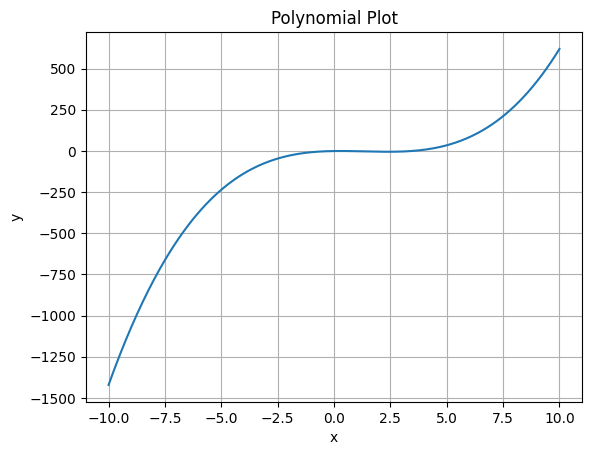

In [1]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np

# Assuming majority_voted_ans is a polynomial
def type_check(expression):
    # Here you can define your type check logic for polynomial
    return isinstance(expression, sp.Poly)

def draw_polynomial_plot(polynomial_expr):
    # Convert sympy polynomial to a lambda function for evaluation
    poly_lambda = sp.lambdify(sp.symbols('x'), polynomial_expr, 'numpy')
    
    # Define the range for plotting the polynomial
    x_vals = np.linspace(-10, 10, 400)
    y_vals = poly_lambda(x_vals)
    
    # Plot the polynomial
    plt.plot(x_vals, y_vals)
    plt.title('Polynomial Plot')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

# Example usage
x = sp.symbols('x')
majority_voted_ans = sp.Poly(x**3 - 4*x**2 + 2*x - 1)

if type_check(majority_voted_ans):
    # Extract the polynomial expression from the Poly object
    polynomial_expr = majority_voted_ans.as_expr()
    draw_polynomial_plot(polynomial_expr)


# now making for all types 

In [3]:
!pip install gradio
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr

# Polynomial type check function
def type_check(expression):
    try:
        sp_expr = sp.sympify(expression)  # Parse the expression
        return isinstance(sp_expr, sp.Poly) or sp_expr.is_polynomial()
    except:
        return False

# Draw polynomial plot
def draw_polynomial_plot(expression):
    if type_check(expression):
        x = sp.symbols('x')
        poly_expr = sp.sympify(expression)  # Convert input to sympy expression
        poly_lambda = sp.lambdify(x, poly_expr, 'numpy')

        # Create the plot
        x_vals = np.linspace(-10, 10, 400)
        y_vals = poly_lambda(x_vals)

        plt.figure()
        plt.plot(x_vals, y_vals)
        plt.title('Polynomial Plot')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid(True)

        # Save the plot to a file
        plot_filename = "polynomial_plot.png"
        plt.savefig(plot_filename)
        plt.close()

        return plot_filename  # Return the filename for Gradio to display

    return "Not a polynomial expression. Please enter a valid polynomial."

# Gradio interface
def gradio_interface(input_expr):
    return draw_polynomial_plot(input_expr)

# Launch Gradio
gr.Interface(fn=gradio_interface, inputs="text", outputs="image").launch()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 59.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 72.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires urllib3<2.0.0, but you have ur